Solving modified version (with GPU acceleration)...
Iteration 1


Iteration 2
Iteration 3
Iteration 4
Iteration 5


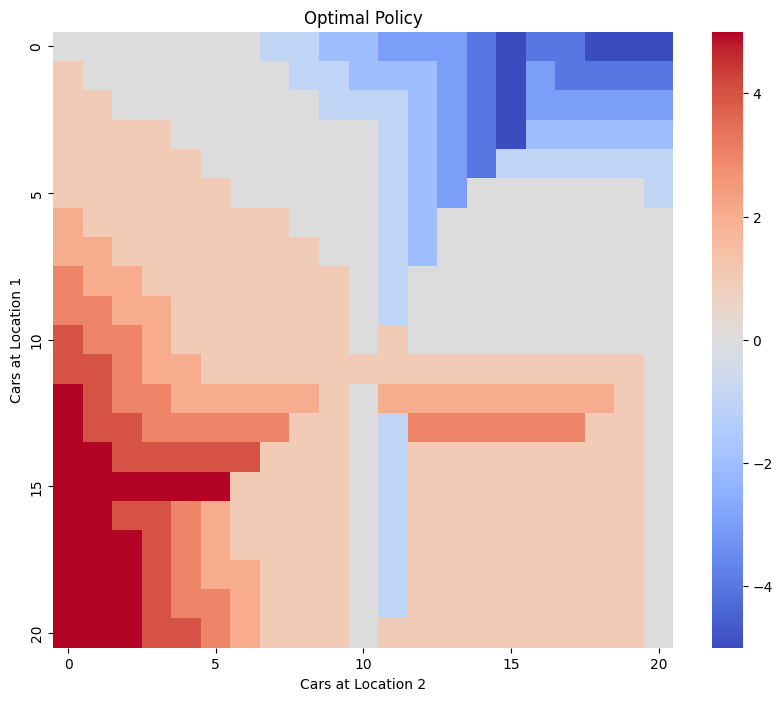

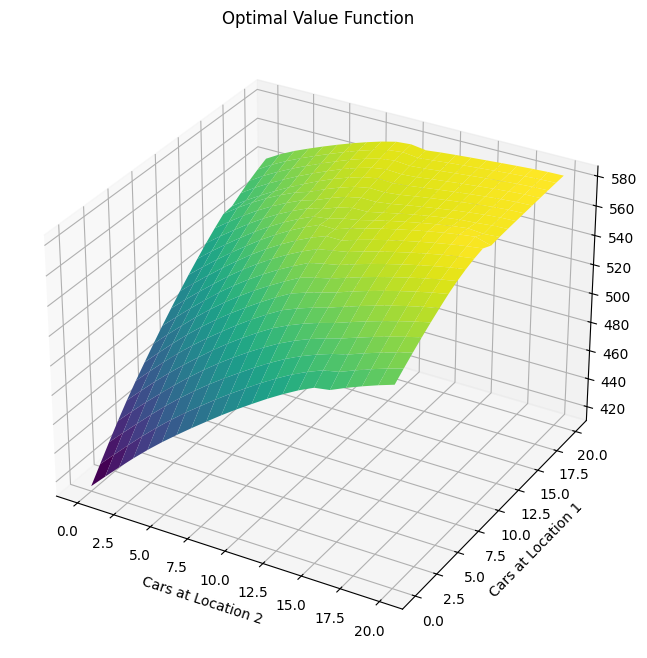

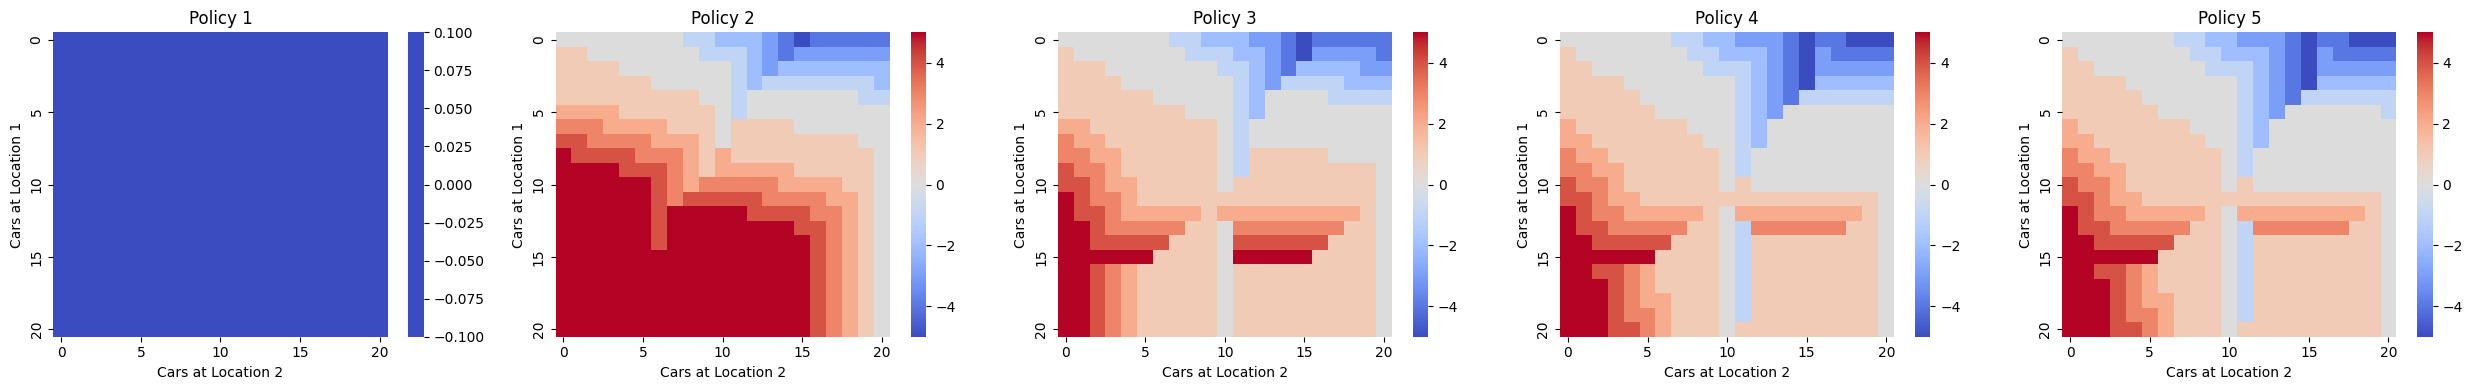


Solving original version (with GPU acceleration)...
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


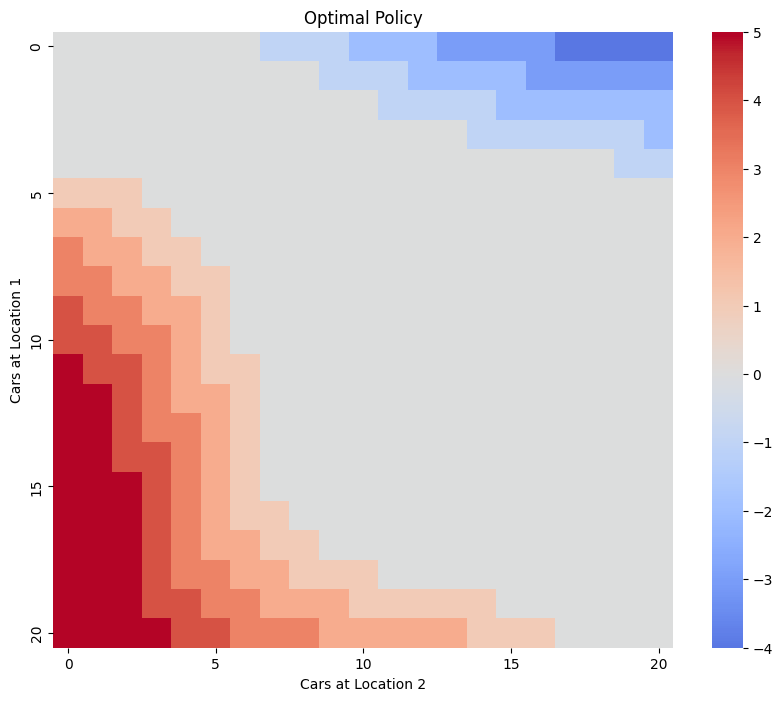

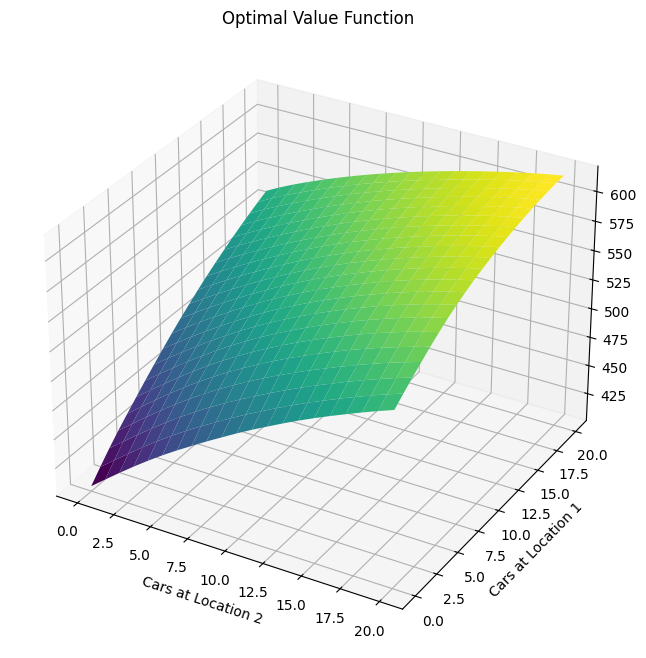

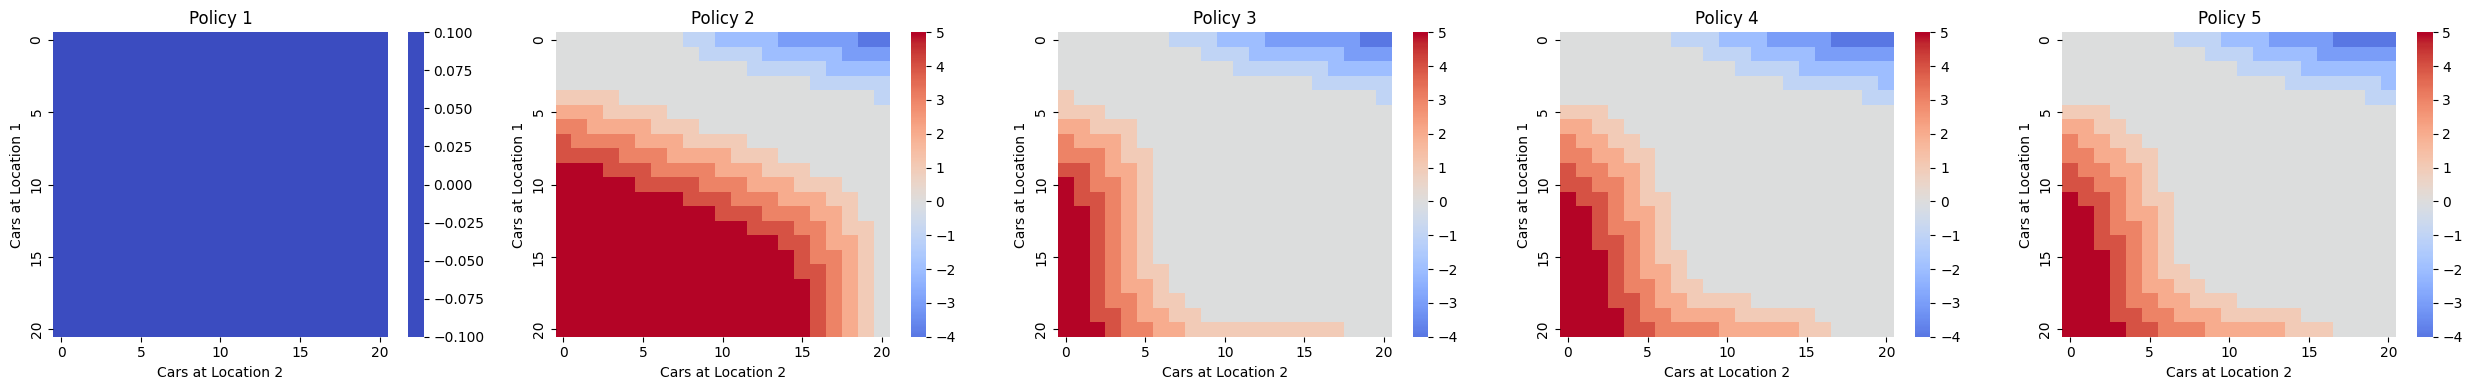

In [5]:
import numpy as np
import cupy as cp
from scipy.stats import poisson
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import seaborn as sns
from dataclasses import dataclass

@dataclass
class CarRentalConfig:
    """Configuration parameters for Jack's Car Rental problem"""
    max_cars: int = 20               # Maximum cars allowed at each location
    max_move_cars: int = 5           # Maximum cars that can be moved overnight
    rental_credit: float = 10.0      # Credit earned per car rental
    move_car_cost: float = 2.0       # Cost per car moved
    parking_lot_cost: float = 4.0    # Extra parking lot cost (modified version)
    parking_threshold: int = 10      # Cars threshold for extra parking cost
    gamma: float = 0.9               # Discount factor
    theta: float = 0.01              # Convergence threshold

    # Poisson parameters
    request_lambda_loc1: float = 3.0  # Expected rentals at location 1
    request_lambda_loc2: float = 4.0  # Expected rentals at location 2
    return_lambda_loc1: float = 3.0   # Expected returns at location 1
    return_lambda_loc2: float = 2.0   # Expected returns at location 2

    # Optimization parameters
    poisson_upper_bound: int = 11    # Upper bound for Poisson probability calculations

class JacksCarRental:
    """Implementation of Jack's Car Rental problem using Policy Iteration with GPU acceleration for expected return computation"""

    def __init__(self, config: CarRentalConfig, modified: bool = True):
        self.config = config
        self.modified = modified
        
        # Initialize value function and policy as GPU arrays (using CuPy)
        self.V = cp.zeros((config.max_cars + 1, config.max_cars + 1))
        self.policy = cp.zeros((config.max_cars + 1, config.max_cars + 1), dtype=cp.int32)
        
        # Cache for Poisson probabilities (stored as CuPy arrays for GPU use)
        self.poisson_cache = self._initialize_poisson_cache()
        
        # Store policy history for visualization (we will convert these GPU arrays to NumPy for plotting)
        self.policy_history: List[cp.ndarray] = []

    def _initialize_poisson_cache(self) -> Dict[float, cp.ndarray]:
        """Pre-compute Poisson probabilities for efficiency (stored on GPU)"""
        lambdas = [
            self.config.request_lambda_loc1,
            self.config.request_lambda_loc2,
            self.config.return_lambda_loc1,
            self.config.return_lambda_loc2
        ]
        return {
            lambda_val: cp.array([
                poisson.pmf(n, lambda_val)
                for n in range(self.config.poisson_upper_bound)
            ])
            for lambda_val in lambdas
        }
    
    def _get_valid_actions(self, cars_loc1: int, cars_loc2: int) -> List[int]:
        """Get valid actions (car movements) for given state"""
        actions = []
        for move in range(-self.config.max_move_cars, self.config.max_move_cars + 1):
            if (0 <= cars_loc1 - move <= self.config.max_cars and 
                0 <= cars_loc2 + move <= self.config.max_cars):
                actions.append(move)
        return actions
    
    def _calculate_movement_cost(self, action: int) -> float:
        """Calculate cost of moving cars between locations"""
        if self.modified:
            # In the modified version, the first car moved to location 2 is free (employee shuttle)
            return self.config.move_car_cost * (abs(action) - 1 if action > 0 else abs(action))
        return self.config.move_car_cost * abs(action)
    
    def _calculate_parking_cost(self, cars_loc1: int, cars_loc2: int) -> float:
        """Calculate additional parking costs if applicable"""
        if not self.modified:
            return 0.0
        
        cost = 0.0
        if cars_loc1 > self.config.parking_threshold:
            cost += self.config.parking_lot_cost
        if cars_loc2 > self.config.parking_threshold:
            cost += self.config.parking_lot_cost
        return cost
    
    def _expected_return(self, cars_loc1: int, cars_loc2: int, action: int) -> float:
        """
        Calculate expected return for a state-action pair using GPU–accelerated vectorized computation.
        The computation integrates over rental requests and returns using pre-computed Poisson probabilities.
        """
        config = self.config
        max_cars = config.max_cars
        
        # Apply action: update car counts at both locations (ensure they remain within bounds)
        cars_loc1_after_move = min(max_cars, max(0, cars_loc1 - action))
        cars_loc2_after_move = min(max_cars, max(0, cars_loc2 + action))
        
        # Immediate reward (includes movement cost and possible parking cost)
        immediate_reward = -(self._calculate_movement_cost(action) +
                             self._calculate_parking_cost(cars_loc1_after_move, cars_loc2_after_move))
        
        # --- GPU accelerated expected reward computation ---
        P = config.poisson_upper_bound
        
        # Rental requests: create grid for possible requests at both locations
        req_range = cp.arange(P)
        req1_grid, req2_grid = cp.meshgrid(req_range, req_range, indexing='ij')  # shape (P, P)
        
        # Joint probabilities for rental requests
        p_req1 = self.poisson_cache[config.request_lambda_loc1]  # shape (P,)
        p_req2 = self.poisson_cache[config.request_lambda_loc2]  # shape (P,)
        joint_req = p_req1[:, None] * p_req2[None, :]             # shape (P, P)
        
        # Compute actual rentals (limited by available cars)
        actual_req1 = cp.minimum(req1_grid, cars_loc1_after_move)
        actual_req2 = cp.minimum(req2_grid, cars_loc2_after_move)
        
        # Rental reward for each (req1, req2) scenario
        rental_reward = (actual_req1 + actual_req2) * config.rental_credit  # shape (P, P)
        
        # Rental returns: create grid for possible returns at both locations
        ret_range = cp.arange(P)
        ret1_grid, ret2_grid = cp.meshgrid(ret_range, ret_range, indexing='ij')  # shape (P, P)
        
        # Joint probabilities for returns
        p_ret1 = self.poisson_cache[config.return_lambda_loc1]  # shape (P,)
        p_ret2 = self.poisson_cache[config.return_lambda_loc2]  # shape (P,)
        joint_ret = p_ret1[:, None] * p_ret2[None, :]             # shape (P, P)
        
        # Expand dimensions so that request and return grids can be combined:
        # actual_req arrays: shape (P, P) -> (P, P, 1, 1)
        actual_req1_exp = actual_req1[:, :, None, None]
        actual_req2_exp = actual_req2[:, :, None, None]
        # Return grids: shape (P, P) -> (1, 1, P, P)
        ret1_exp = ret1_grid[None, None, :, :]
        ret2_exp = ret2_grid[None, None, :, :]
        
        # For each request scenario, compute next state after returns:
        next_cars1 = cp.minimum(max_cars, cars_loc1_after_move - actual_req1_exp + ret1_exp)
        next_cars2 = cp.minimum(max_cars, cars_loc2_after_move - actual_req2_exp + ret2_exp)
        
        # Look up the value function for these next states (self.V is a GPU array)
        V_next = self.V[next_cars1, next_cars2]  # shape (P, P, P, P)
        
        # Combine rental rewards and discounted future values for each return scenario
        expected_returns = rental_reward[:, :, None, None] + config.gamma * V_next  # shape (P, P, P, P)
        # Weight by the joint return probabilities and sum over returns (axes 2 and 3)
        expected_returns = cp.sum(joint_ret[None, None, :, :] * expected_returns, axis=(2, 3))  # shape (P, P)
        
        # Weight by the joint rental request probabilities and sum over requests (axes 0 and 1)
        total_expected = cp.sum(joint_req * expected_returns)
        
        return (immediate_reward + total_expected).item()
    
    def policy_evaluation(self) -> None:
        """Evaluate current policy until convergence"""
        while True:
            delta = 0.0
            # Loop over all states (state space is small so Python loops are acceptable)
            for i in range(self.config.max_cars + 1):
                for j in range(self.config.max_cars + 1):
                    v = float(self.V[i, j].item())
                    # Note: self.policy is a GPU array; convert element to Python int for computation
                    action = int(self.policy[i, j].item())
                    self.V[i, j] = self._expected_return(i, j, action)
                    delta = max(delta, abs(v - float(self.V[i, j].item())))
            if delta < self.config.theta:
                break
    
    def policy_improvement(self) -> bool:
        """Improve policy and return whether it's stable"""
        policy_stable = True
        
        for i in range(self.config.max_cars + 1):
            for j in range(self.config.max_cars + 1):
                old_action = int(self.policy[i, j].item())
                
                # Find best action over all valid moves from state (i, j)
                best_value = float('-inf')
                best_action = None
                
                for action in self._get_valid_actions(i, j):
                    value = self._expected_return(i, j, action)
                    if value > best_value:
                        best_value = value
                        best_action = action
                
                self.policy[i, j] = best_action
                if old_action != best_action:
                    policy_stable = False
        
        return policy_stable
    
    def solve(self) -> Tuple[cp.ndarray, cp.ndarray]:
        """Run policy iteration until convergence"""
        iteration = 0
        while True:
            print(f"Iteration {iteration + 1}")
            # Save a copy of the current policy (stored as a GPU array)
            self.policy_history.append(self.policy.copy())
            
            # Policy Evaluation (updates self.V on GPU)
            self.policy_evaluation()
            
            # Policy Improvement (updates self.policy on GPU)
            policy_stable = self.policy_improvement()
            
            if policy_stable:
                break
                
            iteration += 1
        
        return self.policy, self.V
    
    def visualize_results(self) -> None:
        """Visualize the policy iteration results (convert GPU arrays to CPU for plotting)"""
        # Plot final policy
        plt.figure(figsize=(10, 8))
        sns.heatmap(cp.asnumpy(self.policy), cmap='coolwarm', center=0,
                    xticklabels=5, yticklabels=5)
        plt.title('Optimal Policy')
        plt.xlabel('Cars at Location 2')
        plt.ylabel('Cars at Location 1')
        plt.show()
        
        # Plot value function (convert GPU array to NumPy)
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(range(self.config.max_cars + 1),
                           range(self.config.max_cars + 1))
        # Use cp.asnumpy to bring value function back to CPU memory
        ax.plot_surface(X, Y, cp.asnumpy(self.V), cmap='viridis')
        plt.title('Optimal Value Function')
        plt.xlabel('Cars at Location 2')
        plt.ylabel('Cars at Location 1')
        plt.show()
        
        # Plot policy evolution over iterations
        num_policies = len(self.policy_history)
        fig, axes = plt.subplots(1, num_policies, figsize=(5*num_policies, 4))
        if num_policies == 1:
            axes = [axes]
        
        for idx, policy in enumerate(self.policy_history):
            sns.heatmap(cp.asnumpy(policy), cmap='coolwarm', center=0, ax=axes[idx],
                        xticklabels=5, yticklabels=5)
            axes[idx].set_title(f'Policy {idx+1}')
            axes[idx].set_xlabel('Cars at Location 2')
            axes[idx].set_ylabel('Cars at Location 1')
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize problem configuration
    config = CarRentalConfig()
    
    # Solve the modified version using GPU acceleration for the expected return computation
    print("Solving modified version (with GPU acceleration)...")
    jcr_modified = JacksCarRental(config, modified=True)
    optimal_policy, optimal_value = jcr_modified.solve()
    jcr_modified.visualize_results()
    
    # Solve the original version (without the modified cost) using GPU acceleration
    print("\nSolving original version (with GPU acceleration)...")
    jcr_original = JacksCarRental(config, modified=False)
    optimal_policy, optimal_value = jcr_original.solve()
    jcr_original.visualize_results()